In [1]:
import numpy as np
import cv2
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
path = "/home/jakobtroidl/Desktop/neural-volumes/data/hemibrain-volume-noisy-large/test_sequence/15750_18505_17484/8.png"

# Load the image (assuming it's a grayscale image)
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Apply Fast Fourier Transform
f_transform = fft2(image)
f_shift = fftshift(f_transform)
# Compute magnitude spectrum
magnitude_spectrum = np.log(np.abs(f_shift) + 1) # Adding 1 to avoid log(0)
# Find the maximum frequency
max_frequency = np.max(magnitude_spectrum)

print(f"Maximum Frequency: {max_frequency}")

Maximum Frequency: 14.73704949389145


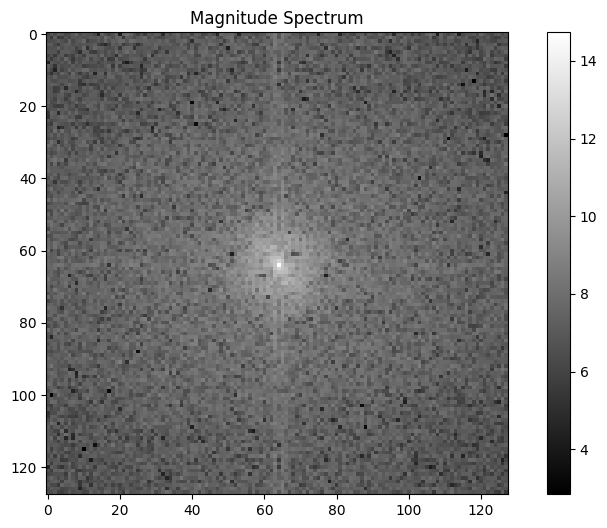

In [3]:
# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()



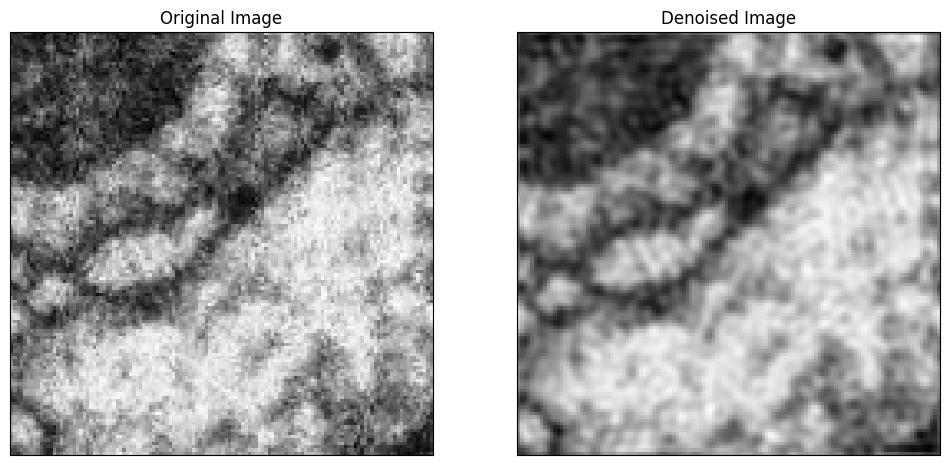

In [11]:
# Load the image (converting to grayscale)
image = Image.open(path).convert('L')
image_np = np.array(image)

# Compute the 2D Fourier Transform of the image
f_transform = np.fft.fft2(image_np)
f_shifted = np.fft.fftshift(f_transform)

# Create a low-pass filter mask (circular mask)
rows, cols = image_np.shape
crow, ccol = rows // 2 , cols // 2
radius = 30 # Radius of the low-pass filter, adjust as needed
low_pass = np.zeros((rows, cols), dtype=np.uint8)
y, x = np.ogrid[:rows, :cols]
mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
low_pass[mask_area] = 1

# Apply the mask/filter
f_shifted_filtered = f_shifted * low_pass

# Inverse Fourier Transform to get the denoised image back
f_ishifted = np.fft.ifftshift(f_shifted_filtered)
img_back = np.fft.ifft2(f_ishifted)
img_back = np.abs(img_back)



# plt.figure(figsize=(10, 6))
# plt.imshow(f_ishifted, cmap='gray')
# plt.title('Magnitude Spectrum')
# plt.colorbar()
# plt.show()

# Display the original and denoised images
plt.figure(figsize=(12, 6))

plt.subplot(121), plt.imshow(image_np, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Denoised Image'), plt.xticks([]), plt.yticks([])

plt.show()
